

Objective:

To explore and visualize weather data for Ottawa, ON, for the year 2011. The data is retrieved through OGC APIs and web services, specifically using the GeoMET API. The process involves fetching, processing, and visualizing the weather data including temperatures and precipitation, and plotting the location data on geographic maps.
    

In [ ]:
import subprocess

# Prepare a list of necessary libraries that we need to install.
needed_libraries = ["OWSLib", "matplotlib", "pandas", "folium", "requests"]

# Automatically install each library using pip.
for library in needed_libraries:
    subprocess.run(["pip", "install", library])

# Importing various utilities and tools after installation
from datetime import date
import json
import math
from textwrap import fill
import requests

# Importing visualization and data handling libraries
from matplotlib import pyplot as plt, dates as mdates
from osgeo import ogr, osr
from owslib.ogcapi.features import Features
import numpy as np
import pandas as pd
from tabulate import tabulate


### Initial Setup
Installed and imported all necessary Python libraries that are required to handle the data retrieval, processing, and visualization tasks. Libraries such as `OWSLib` and `matplotlib` are crucial for accessing weather data via APIs and for plotting, respectively.

In [ ]:
# Location details
search_address = '560 Rochester St, Ottawa, ON, CA'

# Define the time range for data retrieval
start_period = date(2011, 1, 1)
end_period = date(2011, 12, 31)

# Fetch location data from OpenStreetMap's Nominatim service
response = requests.get(f"https://nominatim.openstreetmap.org/search?q={search_address}&format=json")
location_data = response.json()
latitude = float(location_data[0]['lat'])
longitude = float(location_data[0]['lon'])

# Set the radius for geographical queries in kilometers
radius_km = 100

# Define the spatial reference system using an ESPG code
# This uses NAD83 / Statistics Canada Lambert for accurate projection in Canada
spatial_reference_code = 3347

# The following line enables inline plotting for Jupyter Notebooks
%matplotlib inline


### Location and Time Period Setup
The location for which the weather data need to be gathered ('560 Rochester St, Ottawa, ON, CA') is specified and the time range for the year 2011 is set. This information is used to fetch the relevant weather data from the GeoMET API.

In [ ]:
# Calculate the bounding box in degrees from the specified buffer radius
# Approximate conversion from kilometers to degrees:
# For Latitude: 1 km approximately equals 0.009 degrees
# For Longitude at the 49th parallel: 1 km approximately equals 0.014 degrees
bounding_box = [
    longitude - radius_km * 0.02,  # West boundary
    latitude - radius_km * 0.01,   # South boundary
    longitude + radius_km * 0.02,  # East boundary
    latitude + radius_km * 0.01,   # North boundary
]

# Create a string representation of the time period for queries
formatted_time_range = f"{start_period}/{end_period}"


### Data Retrieval
This cell calculates the bounding box based on the location's latitude and longitude for querying the weather data. It also prepares for the API request to fetch the weather data.

In [ ]:
# Set up a connection to the OpenAPI for Environment and Climate Change Canada
weather_features = Features("https://api.weather.gc.ca/")
climate_station_data = weather_features.collection_items(
    "climate-stations", bbox=bounding_box, STATUS_EN="Active"
)

# Ensure that the data contains 'features' to proceed
if "features" in climate_station_data:
    climate_station_data = json.dumps(climate_station_data, indent=4)
else:
    raise ValueError(
        "No climate stations found. Check the coordinates and try again."
    )

# Open the GeoJSON layer containing climate station data
geojson_driver = ogr.GetDriverByName("GeoJSON")
climate_data_source = geojson_driver.Open(climate_station_data, 0)
climate_layer = climate_data_source.GetLayer()

# Retrieve and set the spatial reference from the climate stations layer
input_spatial_ref = climate_layer.GetSpatialRef()
spatial_ref = osr.SpatialReference(str(input_spatial_ref))
spatial_ref_code = spatial_ref.GetAuthorityCode(None)
input_spatial_ref.ImportFromEPSG(int(spatial_ref_code))

# Define the desired projection for spatial data using the specified ESPG code
projected_spatial_ref = osr.SpatialReference()
projected_spatial_ref.ImportFromEPSG(spatial_reference_code)

# Transform coordinates from the original to the desired projection
coord_transform = osr.CoordinateTransformation(input_spatial_ref, projected_spatial_ref)

# Construct a buffer zone around the specified point to select relevant stations
reference_point = ogr.Geometry(ogr.wkbPoint)
reference_point.AddPoint(longitude, latitude)
reference_point.Transform(coord_transform)
station_search_buffer = reference_point.Buffer(radius_km * 1000)  # Convert km to meters for the buffer

# Collect all stations within the buffer zone
nearby_stations = []

for feature in climate_layer:
    geometry = feature.GetGeometryRef().Clone()
    geometry.Transform(coord_transform)
    if geometry.Intersects(station_search_buffer):
        nearby_stations.append(feature.GetField("STN_ID"))

# Error handling if no stations are found within the buffer zone
if not nearby_stations:
    raise ValueError(
        f"No climate stations found within {radius_km} km of the specified coordinates."
    )

# Determine the closest station with relevant data
closest_station = None
shortest_distance = float('inf')

for feature in climate_layer:
    geometry = feature.GetGeometryRef()
    station_latitude = geometry.GetY()
    station_longitude = geometry.GetX()
    distance_to_station = math.sqrt((station_latitude - latitude)**2 + (station_longitude - longitude)**2)

    # Fetch climate data for the station within the specified time range
    station_climate_data = weather_features.collection_items(
        "climate-daily",
        bbox=bounding_box,
        datetime=formatted_time_range,
        STN_ID=feature.GetField("STN_ID"),
    )

    if station_climate_data["features"]:
        if distance_to_station < shortest_distance:
            shortest_distance = distance_to_station
            closest_station = feature

# Display the closest station with data if found
if closest_station:
    closest_station_id = closest_station.GetField("STN_ID")
    print(f"The closest climate station with data to the address is {closest_station_id}.")
else:
    print("No climate stations within the buffer zone have data for the specified time period.")

# Fetch detailed climate data for the closest station with data
final_climate_data = weather_features.collection_items(
        "climate-daily",
        bbox=bounding_box,
        datetime=formatted_time_range,
        STN_ID=closest_station_id if closest_station else None,
    )
final_climate_data["features"]


The closest climate station with data to the address is 4333.


[{'id': '6105976.2011.1.1',
  'type': 'Feature',
  'geometry': {'coordinates': [-75.71666666666667, 45.38333333333333],
   'type': 'Point'},
  'properties': {'TOTAL_RAIN': 4.2,
   'MAX_TEMPERATURE_FLAG': None,
   'MEAN_TEMPERATURE_FLAG': None,
   'TOTAL_SNOW': 0,
   'PROVINCE_CODE': 'ON',
   'DIRECTION_MAX_GUST': None,
   'MAX_REL_HUMIDITY_FLAG': None,
   'MIN_TEMPERATURE_FLAG': None,
   'COOLING_DEGREE_DAYS_FLAG': None,
   'TOTAL_RAIN_FLAG': None,
   'COOLING_DEGREE_DAYS': 0,
   'HEATING_DEGREE_DAYS_FLAG': None,
   'MIN_REL_HUMIDITY': None,
   'MIN_TEMPERATURE': 1.7,
   'LOCAL_DATE': '2011-01-01 00:00:00',
   'TOTAL_PRECIPITATION': 4.2,
   'MEAN_TEMPERATURE': 4.7,
   'TOTAL_SNOW_FLAG': None,
   'LOCAL_YEAR': 2011,
   'HEATING_DEGREE_DAYS': 13.3,
   'TOTAL_PRECIPITATION_FLAG': None,
   'STATION_NAME': 'OTTAWA CDA',
   'DIRECTION_MAX_GUST_FLAG': None,
   'LOCAL_DAY': 1,
   'SPEED_MAX_GUST_FLAG': None,
   'CLIMATE_IDENTIFIER': '6105976',
   'SPEED_MAX_GUST': None,
   'MAX_REL_HUMIDITY': 

### Data Processing
In this section, the fetched weather data is processed for temperatures and precipitation, preparing it for analysis and visualization.

In [ ]:
# Fetch climate data for the closest station that has been identified
daily_climate_data = weather_features.collection_items(
    "climate-daily",
    bbox=bounding_box,
    datetime=formatted_time_range,
    STN_ID=closest_station_id if closest_station else None,
)

# Access the 'features' key from the retrieved climate data to process it further
daily_climate_data["features"]


[{'id': '6105976.2011.1.1',
  'type': 'Feature',
  'geometry': {'coordinates': [-75.71666666666667, 45.38333333333333],
   'type': 'Point'},
  'properties': {'TOTAL_RAIN': 4.2,
   'MAX_TEMPERATURE_FLAG': None,
   'MEAN_TEMPERATURE_FLAG': None,
   'TOTAL_SNOW': 0,
   'PROVINCE_CODE': 'ON',
   'DIRECTION_MAX_GUST': None,
   'MAX_REL_HUMIDITY_FLAG': None,
   'MIN_TEMPERATURE_FLAG': None,
   'COOLING_DEGREE_DAYS_FLAG': None,
   'TOTAL_RAIN_FLAG': None,
   'COOLING_DEGREE_DAYS': 0,
   'HEATING_DEGREE_DAYS_FLAG': None,
   'MIN_REL_HUMIDITY': None,
   'MIN_TEMPERATURE': 1.7,
   'LOCAL_DATE': '2011-01-01 00:00:00',
   'TOTAL_PRECIPITATION': 4.2,
   'MEAN_TEMPERATURE': 4.7,
   'TOTAL_SNOW_FLAG': None,
   'LOCAL_YEAR': 2011,
   'HEATING_DEGREE_DAYS': 13.3,
   'TOTAL_PRECIPITATION_FLAG': None,
   'STATION_NAME': 'OTTAWA CDA',
   'DIRECTION_MAX_GUST_FLAG': None,
   'LOCAL_DAY': 1,
   'SPEED_MAX_GUST_FLAG': None,
   'CLIMATE_IDENTIFIER': '6105976',
   'SPEED_MAX_GUST': None,
   'MAX_REL_HUMIDITY': 

### Temperature Visualization
This cell creates visualizations for the temperature data, including separate plots for minimum, mean, and maximum temperatures and a combined plot for comparative analysis.

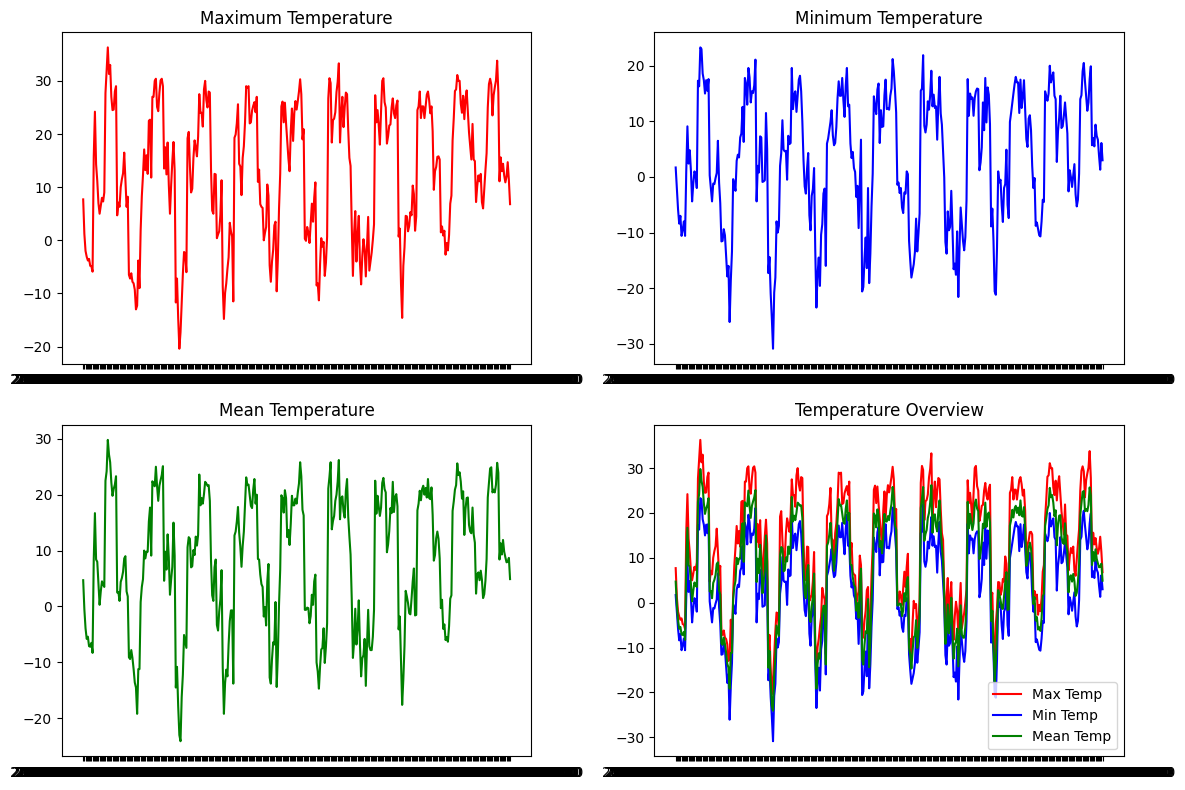

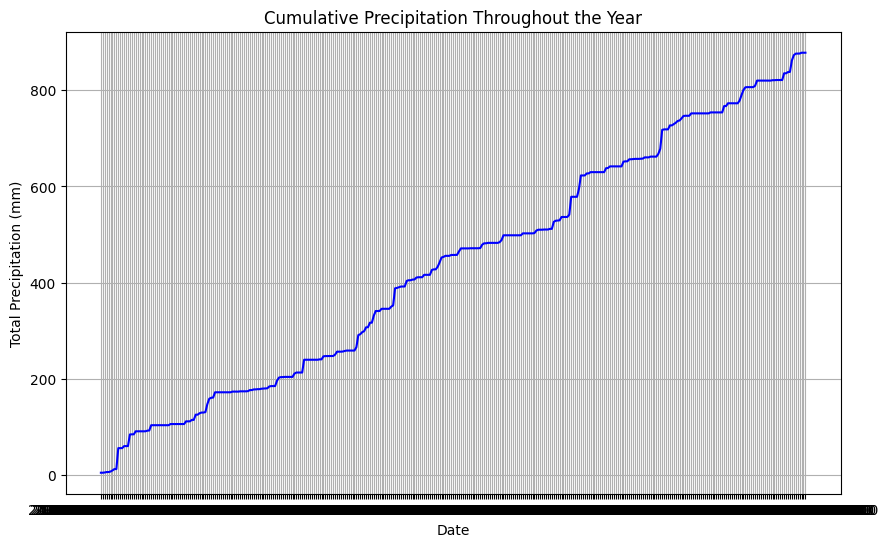

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Transform JSON climate data into a structured Pandas DataFrame
formatted_climate_records = [
    {
        "Station Name": feature["properties"]["STATION_NAME"],
        "Date": feature["properties"]["LOCAL_DATE"],
        "Min Temp (°C)": feature["properties"]["MIN_TEMPERATURE"],
        "Mean Temp (°C)": feature["properties"]["MEAN_TEMPERATURE"],
        "Max Temp (°C)": feature["properties"]["MAX_TEMPERATURE"],
        "Precipitation (mm)": feature["properties"]["TOTAL_PRECIPITATION"],
        "Latitude": feature["geometry"]["coordinates"][1],
        "Longitude": feature["geometry"]["coordinates"][0],
    }
    for feature in daily_climate_data["features"]
]

# Create a DataFrame from the structured data
climate_data_frame = pd.DataFrame(
    formatted_climate_records,
    columns=[
        "Station Name", "Date", "Min Temp (°C)", "Mean Temp (°C)", "Max Temp (°C)", "Precipitation (mm)"
    ],
)

# Visualization of temperature trends
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes[0, 0].plot(climate_data_frame['Date'], climate_data_frame['Max Temp (°C)'], color='red')
axes[0, 0].set_title('Maximum Temperature')
axes[0, 1].plot(climate_data_frame['Date'], climate_data_frame['Min Temp (°C)'], color='blue')
axes[0, 1].set_title('Minimum Temperature')
axes[1, 0].plot(climate_data_frame['Date'], climate_data_frame['Mean Temp (°C)'], color='green')
axes[1, 0].set_title('Mean Temperature')

# Combined temperature plot
axes[1, 1].plot(climate_data_frame['Date'], climate_data_frame['Max Temp (°C)'], color='red', label='Max Temp')
axes[1, 1].plot(climate_data_frame['Date'], climate_data_frame['Min Temp (°C)'], color='blue', label='Min Temp')
axes[1, 1].plot(climate_data_frame['Date'], climate_data_frame['Mean Temp (°C)'], color='green', label='Mean Temp')
axes[1, 1].legend()
axes[1, 1].set_title('Temperature Overview')

plt.tight_layout()
plt.show()

# Visualize cumulative precipitation throughout the year
plt.figure(figsize=(10, 6))
plt.plot(climate_data_frame['Date'], climate_data_frame['Precipitation (mm)'].cumsum(), color='blue')
plt.title('Cumulative Precipitation Throughout the Year')
plt.xlabel('Date')
plt.ylabel('Total Precipitation (mm)')
plt.grid(True)
plt.show()


### Precipitation Visualization
Here, the cumulative precipitation is plotted over the year 2011 to analyze precipitation trends in Ottawa.

In [ ]:
import folium

# Define the coordinates for the provided address
address_coordinates = (latitude, longitude)

# Initialize a map centered on the provided address with appropriate zoom
interactive_map = folium.Map(location=address_coordinates, zoom_start=10)

# Place a custom marker at the address location
folium.Marker(
    address_coordinates,
    popup='Provided Address',
    icon=folium.Icon(color='red')
).add_to(interactive_map)

# Extract coordinates for the closest weather station
station_longitude = closest_station.GetGeometryRef().GetX()
station_latitude = closest_station.GetGeometryRef().GetY()

# Define coordinates for the closest observation station
closest_station_coordinates = (station_latitude, station_longitude)

# Add a marker for the closest observation station on the map
folium.Marker(
    closest_station_coordinates,
    popup='Closest Climate Station',
    icon=folium.Icon(color='blue')
).add_to(interactive_map)

# Render the interactive map
interactive_map


### Geographic Mapping
This cell uses Folium to create an interactive map showing the location of the weather observation station and the specified address.

### Seasonal Analysis Setup
Prepares the weather data for seasonal analysis by classifying each date into a corresponding season based on predefined date ranges.

In [ ]:
# Create a copy of the original DataFrame for further manipulation
climate_data_copy = climate_data_frame.copy()

# Convert the 'Date' column to datetime format for easier manipulation and analysis
climate_data_copy['Date'] = pd.to_datetime(climate_data_copy['Date'])


### Seasonal Temperature Visualization
Generates plots for each season displaying temperature trends and the average mean temperature, providing insights into seasonal variations.

In [ ]:
# Define a function to determine the season based on specific date criteria
def determine_season(date):
    if (date.month == 3 and date.day >= 20) or (date.month == 4) or (date.month == 5) or (date.month == 6 and date.day <= 20):
        return 'Spring'
    elif (date.month == 6 and date.day >= 21) or (date.month == 7) or (date.month == 8) or (date.month == 9 and date.day <= 22):
        return 'Summer'
    elif (date.month == 9 and date.day >= 23) or (date.month == 10) or (date.month == 11) or (date.month == 12 and date.day <= 20):
        return 'Autumn'
    else:
        return 'Winter'

# Ensure the 'Date' column is in datetime format for accurate season classification
climate_data_copy['Date'] = pd.to_datetime(climate_data_copy['Date'])

# Apply the season classification function to each date in the 'Date' column
climate_data_copy['Season'] = climate_data_copy['Date'].apply(determine_season)


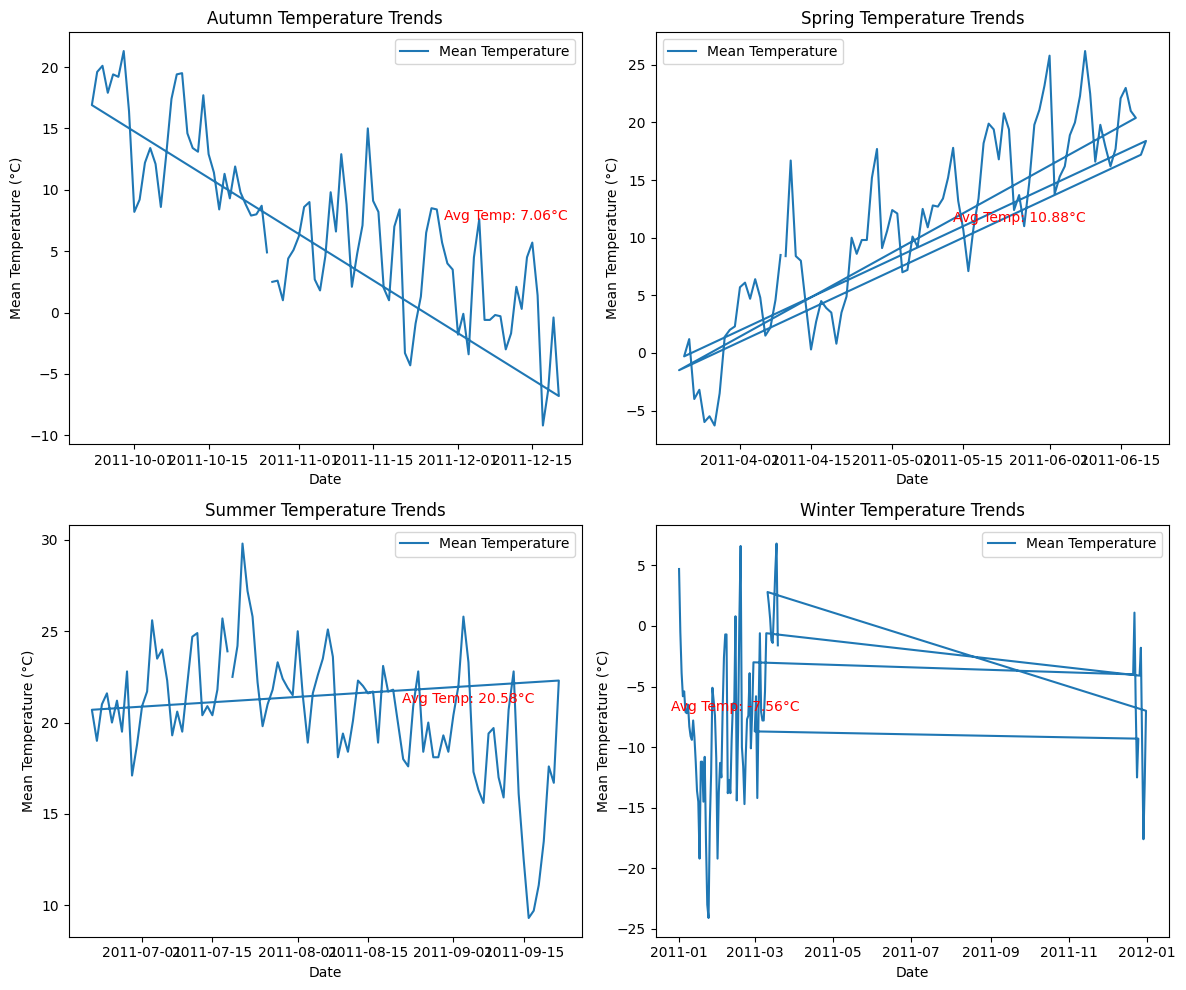

In [ ]:
# Group the data by season and compute the average mean temperature for each season
seasonal_average_temperatures = climate_data_copy.groupby('Season')['Mean Temp (°C)'].mean()

# Set up the plotting area with individual subplots for each season
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot mean temperature trends for each season
for i, season in enumerate(seasonal_average_temperatures.index):
    ax = axes[i]
    season_data = climate_data_copy[climate_data_copy['Season'] == season]
    ax.plot(season_data['Date'], season_data['Mean Temp (°C)'], label='Mean Temperature')

    # Calculate and annotate the average mean temperature for the displayed season
    average_temp = seasonal_average_temperatures[season]
    midpoint_index = int(len(season_data) / 2)  # Find the middle of the dataset for labeling
    ax.text(season_data['Date'].iloc[midpoint_index],
            average_temp + 0.5,  # Offset the label slightly above the average line
            f'Avg Temp: {average_temp:.2f}°C',
            horizontalalignment='center',
            fontsize=10,
            color='red')

    # Set the labels and title for each subplot
    ax.set_xlabel('Date')
    ax.set_ylabel('Mean Temperature (°C)')
    ax.set_title(f'{season} Temperature Trends')
    ax.legend()

plt.tight_layout()
plt.show()


From the above results we can conclude that,


- **Seasonal Trends**: The temperature trends follow expected seasonal patterns—rising from Spring, peaking in Summer, decreasing through Autumn, and reaching the lowest in Winter.
- **Temperature Variability**: There is considerable day-to-day variability, especially noticeable in Winter and Summer, which could be due to weather fronts and other atmospheric conditions.
- **Extreme Values**: Winter has some very low extremes, which could be cold waves, while Summer doesn't show extremely high temperatures, suggesting a temperate summer or the absence of heatwaves during this year.
- **Data Quality**: All seasons show some data points that could be outliers or errors (such as very sharp spikes or drops). It would be important to verify these points with station metadata to ensure they are not due to sensor issues or data entry errors.

This seasonal analysis provides valuable insight into the climatic conditions for the year 2011.